# Machine Learning Notebook for bike/parking space predictions

## Section 0: Import Required Libraries

In [1]:
from sqlalchemy import create_engine
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
import pickle

## Section 1: Data preparation

### Section 1.1: Create a function to create to the SQL database

In [2]:
def connect_to_database():
    """Function for connecting to the SQL database"""

    # Create variables to store cretentials
    USER = "admin"
    DB = "dbikes"
    PORT = "3306"
    URL = "database-1.ctesjcult8dm.eu-west-1.rds.amazonaws.com"

    # Read in password from text file
    with open('../mysql_password.txt') as f:
        PASSWORD = ''.join(f.readlines())
        PASSWORD = str(PASSWORD).split()[0]

    # Create engine using credentials
    engine = create_engine(
        "mysql+mysqlconnector://{}:{}@{}:{}/{}".format(USER, PASSWORD, URL, PORT, DB), echo=True)

    # Create connection using engine and return connection
    conn = engine.connect()
    return conn


In [3]:
engine = connect_to_database()

2022-04-01 12:46:49,925 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'sql_mode'
2022-04-01 12:46:49,928 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-01 12:46:49,957 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2022-04-01 12:46:49,959 INFO sqlalchemy.engine.Engine [generated in 0.01106s] {}
2022-04-01 12:46:50,009 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2022-04-01 12:46:50,011 INFO sqlalchemy.engine.Engine [raw sql] {}


### Section 1.2: Read in real time bike/parking space availability data

In [4]:
availability_df = pd.read_sql_query("SELECT * FROM dbikes.availability", engine)

2022-04-01 12:46:50,193 INFO sqlalchemy.engine.Engine SELECT * FROM dbikes.availability
2022-04-01 12:46:50,194 INFO sqlalchemy.engine.Engine [raw sql] {}


### Section 1.3: Remove Duplicate values from real time availability

In [5]:
# Remove duplicates
availability_df.drop_duplicates(inplace=True)

In [6]:
availability_df.head()

,number,available_bikes,available_stands,last_update
0,42,17,13,1644921618000
1,30,15,5,1644922002000
2,54,16,17,1644922012000
3,108,10,25,1644921926000
4,56,9,31,1644922071000


Observations: We anticipate that day of the week and hour of the day will be key indicators of bike/parking space availability, so we will utilise these features in all of our models.

### Section 1.4: Read in weather data

In [7]:
weather_df = pd.read_sql_query("SELECT dt, temperature, pressure, humidity, clouds, visibility, main FROM dbikes.real_time_weather", engine)

2022-04-01 12:47:53,073 INFO sqlalchemy.engine.Engine SELECT dt, temperature, pressure, humidity, clouds, visibility, main FROM dbikes.real_time_weather
2022-04-01 12:47:53,076 INFO sqlalchemy.engine.Engine [raw sql] {}


### Section 1.5: Remove duplicate values from weather

In [8]:
#Drop duplicates
weather_df.drop_duplicates(inplace=True)

In [9]:
weather_df.head()

,dt,temperature,pressure,humidity,clouds,visibility,main
0,1644922267,280,1001,80,75,10000,Clouds
1,1644922316,280,1001,80,75,10000,Clouds
2,1644922617,280,1001,80,75,10000,Clouds
3,1644922917,280,1001,79,75,10000,Clouds
4,1644923217,280,1001,79,75,10000,Clouds


Observations: We expect that temparature will have an impact on bike availability. Logically, we would expect that the volume of cyclists will decrease as it gets colder, as the experience of cycling will be less pleasant. Main will also be an important feature. Main assigns a category to the weather in each record (eg: clouds, rain, drizzle etc.). We expect other variables to be less impactful, however, we will perform EDA to identify potentially worthwhile features, and will create several different models to test the impact of adding/removing certain variables.

### Section 1.6: Rename last update column in availability dataframe to dt to help with the merging of the availability and weather dataframes

In [10]:
#Changes the name of the column
availability_df.rename(columns={"last_update": "dt"}, inplace=True)
availability_df.columns

Index(['number', 'available_bikes', 'available_stands', 'dt'], dtype='object')

### Section 1.7: Change the type of the dt variable to an np.int64 type for merging

In [11]:
availability_df["dt"] = availability_df["dt"].astype(np.int64)
weather_df["dt"]= weather_df["dt"].astype(np.int64)

### Section 1.8: Sort the dt columns for merging

In [12]:
availability_df.sort_values(by="dt", inplace=True)
weather_df.sort_values(by="dt", inplace=True)

### Section 1.9: Convert seconds to milliseconds in dt column in availability so that it is comparable with the corresponding weather column

In [13]:
#Converts seconds to miliseconds
availability_df["dt"] = availability_df["dt"] // 1000

### Section 1.10: Merge weather and availability dataframes

In [14]:
df=pd.merge_asof(availability_df, weather_df, on="dt", direction="nearest")

### Section 1.11: Convert temperature from Kelvin to Celcius

In [15]:
df["temperature"] = df["temperature"] - 273.15

### Section 1.12: Transform the dt column to get hour of the day and day of the week

In [16]:
df["dt"] = pd.to_datetime(df["dt"], unit="s")
df["day_of_week"] = df["dt"].dt.day_name()
df["hour"] = df["dt"].dt.hour

### Section 1.13: Convert categorical variables to "category" data type

In [17]:
df.dtypes

number                       int64
available_bikes              int64
available_stands             int64
dt                  datetime64[ns]
temperature                float64
pressure                     int64
humidity                     int64
clouds                       int64
visibility                   int64
main                        object
day_of_week                 object
hour                         int64
dtype: object

In [18]:
df["main"] = df["main"].astype("category")
df["day_of_week"] = df["day_of_week"].astype("category")
df["hour"] = df["hour"].astype("category")

In [19]:
df.dtypes

number                       int64
available_bikes              int64
available_stands             int64
dt                  datetime64[ns]
temperature                float64
pressure                     int64
humidity                     int64
clouds                       int64
visibility                   int64
main                      category
day_of_week               category
hour                      category
dtype: object

## Section 2: Feature Plots

### Section 2.1: Temperature

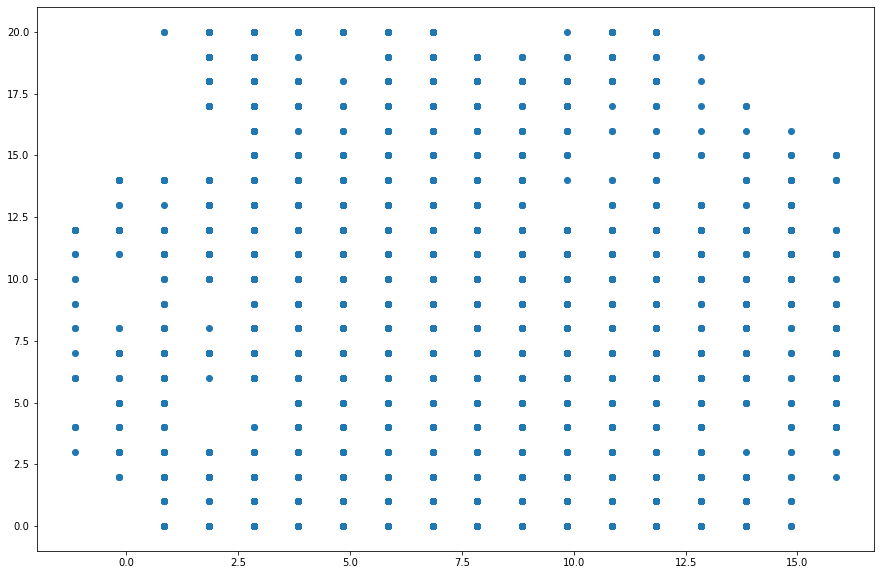

In [20]:
plt.figure(figsize=(15, 10))
plt.scatter(df["temperature"][df["number"] == 2], df["available_bikes"][df["number"] == 2])

Observations: We cannot visually identify any relationship between temperature and bike availability for station 2, suggesting that temperature is not a determinant of bike availability.

### Section 2.2: Pressure

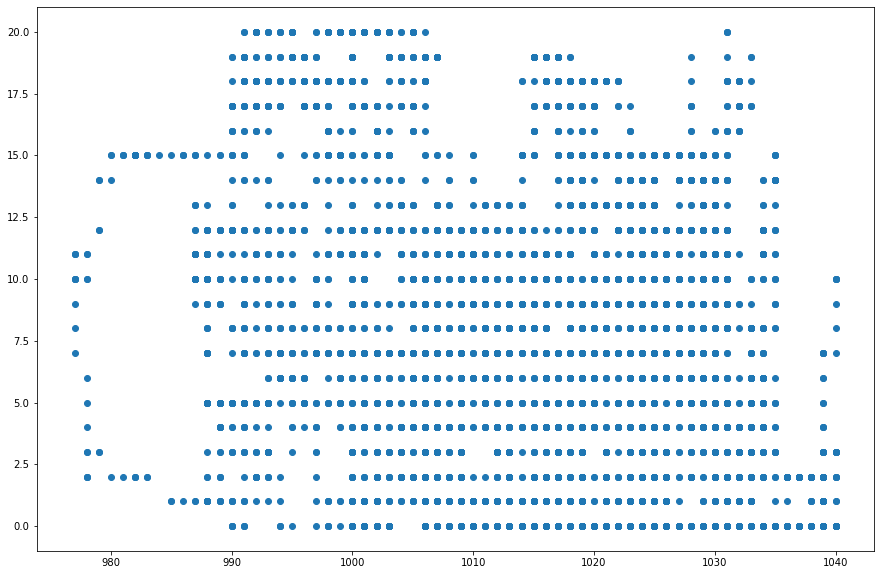

In [21]:
plt.figure(figsize=(15, 10))
plt.scatter(df["pressure"][df["number"] == 2], df["available_bikes"][df["number"] == 2])

Observations: We cannot visually identify any relationship between pressure and bike availability for station 2, suggesting that pressure is not a determinant of bike availability.

### Section 2.3: Humidity

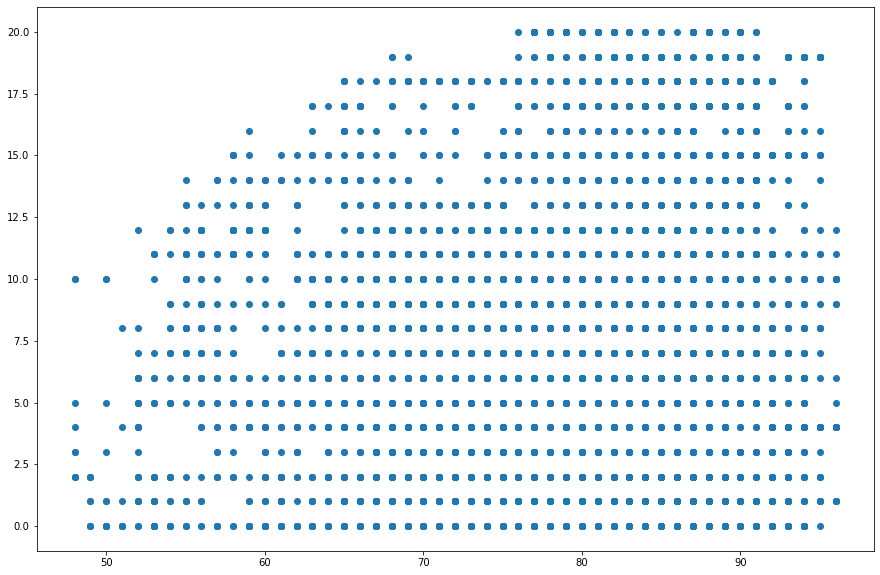

In [22]:
plt.figure(figsize=(15, 10))
plt.scatter(df["humidity"][df["number"] == 2], df["available_bikes"][df["number"] == 2])

Observations: We cannot visually identify any relationship between humidity and bike availability for station 2, suggesting that humidity is not a determinant of bike availability.

### Section 2.4: Clouds

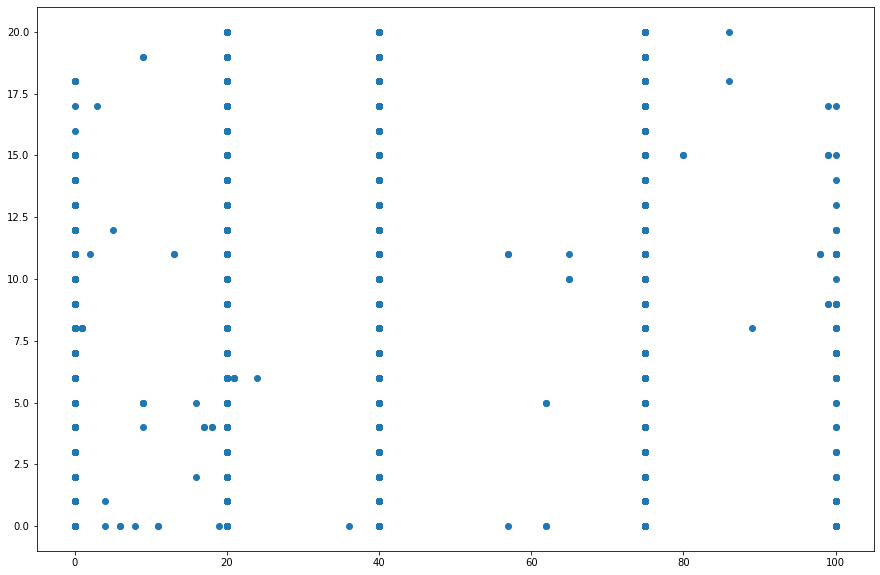

In [23]:
plt.figure(figsize=(15, 10))
plt.scatter(df["clouds"][df["number"] == 2], df["available_bikes"][df["number"] == 2])

Observations: We cannot visually identify any relationship between clouds and bike availability for station 2, suggesting that clouds is not a determinant of bike availability.

### Section 2.5: Visibility

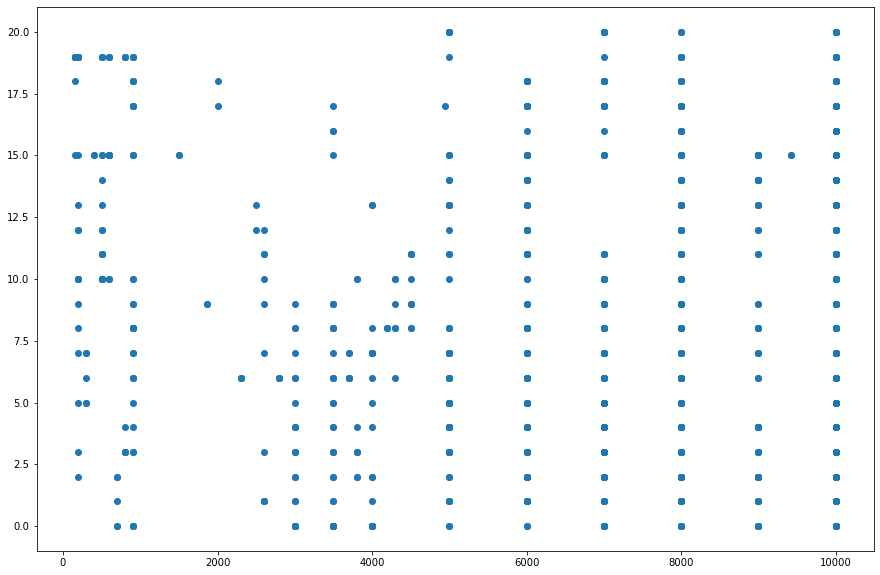

In [24]:
plt.figure(figsize=(15, 10))
plt.scatter(df["visibility"][df["number"] == 2], df["available_bikes"][df["number"] == 2])

Observations: We cannot visually identify any relationship between visibility and bike availability for station 2, suggesting that visibility is not a determinant of bike availability.

### Section 2.6: Weather description/main

<AxesSubplot:title={'center':'available_bikes'}, xlabel='[main]'>

<Figure size 432x288 with 0 Axes>

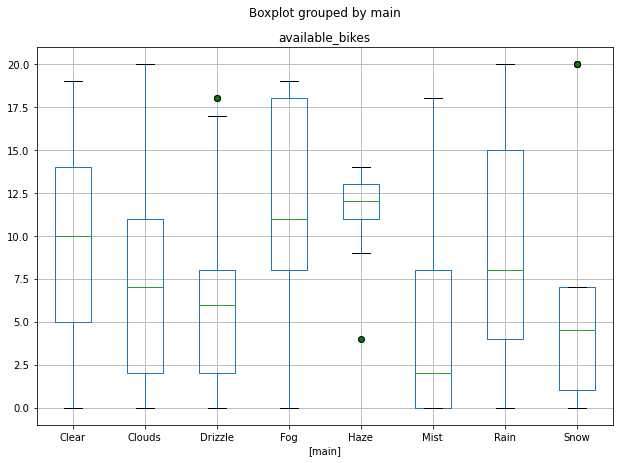

In [25]:
station_2_df = df[df["number"] == 2]
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
station_2_df.boxplot(column=['available_bikes'], by=['main'], flierprops=flierprops, figsize=(10,7))

Observations: We note that there appears to be a relationship between main and available bikes. On clear days, there is a noticable availability of bikes, while in other days, there are fewer bikes available. This aligns with our expectations, as we would assume that the weather in general (whether it's cloudy, rainy etc.) would have a larger affect than other aspects of the weather

### Section 2.7: Day of the week

<AxesSubplot:title={'center':'available_bikes'}, xlabel='[day_of_week]'>

<Figure size 432x288 with 0 Axes>

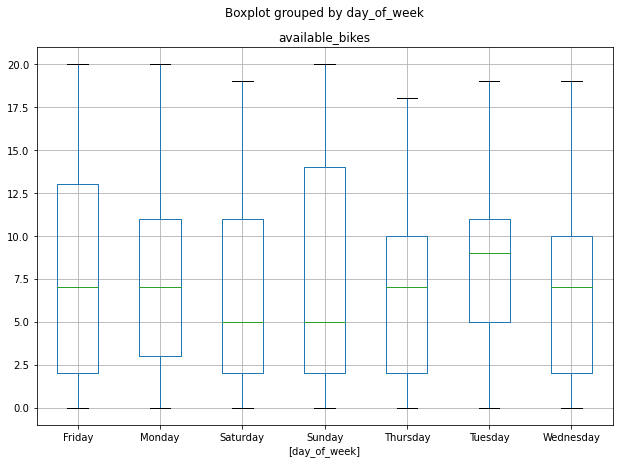

In [26]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
station_2_df.boxplot(column=['available_bikes'], by=['day_of_week'], flierprops=flierprops, figsize=(10,7))

Observations: We note that there appears to be a relationship between the day of the week and available bikes. As we would expect, the weekends in particular appear to have a low average available bike count. The usage patterns also do appear to vary within the week also.

### Section 2.8: Hour of the day

<AxesSubplot:title={'center':'available_bikes'}, xlabel='[hour]'>

<Figure size 432x288 with 0 Axes>

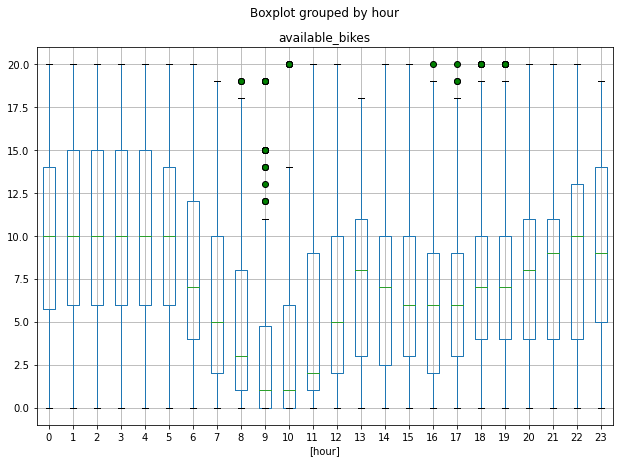

In [27]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
station_2_df.boxplot(column=['available_bikes'], by=['hour'], flierprops=flierprops, figsize=(10,7))

Observations: We see a strong relationship here between the hour of the day and the availability of bikes. We can see three defined changepoints, one point early in the morning, where presumably people are going to work, one point around lunchtime, where people are presumably going to lunch, and one point in the evening, where presumably people are going home. This suggests that hour of the day will be our strongest indicator of availability

### Section 2.9: Get a list of station numbers

In [28]:
station_numbers = list(df["number"].unique())

### Section 2.10: Reencode categorical variables using binary encoding

In [29]:
dummy_fields = ["main", "hour", "day_of_week"]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first = False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(dummy_fields, axis=1)

In [30]:
df.columns

Index(['number', 'available_bikes', 'available_stands', 'dt', 'temperature',
       'pressure', 'humidity', 'clouds', 'visibility', 'main_Clear',
       'main_Clouds', 'main_Drizzle', 'main_Fog', 'main_Haze', 'main_Mist',
       'main_Rain', 'main_Snow', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

In [31]:
# Model which includes all weather features
all_weather_features = list(df.columns)[4:]

In [32]:
# Model which includes no weather features
no_weather_features = list(df.columns[17:])

In [33]:
# Model which just includes the weather description/main
with_main = list(df.columns[9:])

In [34]:
with_main_and_temp = list(df.columns[4:5])
with_main_and_temp.extend(list(df.columns[9:]))

## Section 3: Model creation/evaluation

### Section 3.1: Comparison of different ML models on a sample of the data

We decided to compare various different linear regression models to see which one performed the best

In [35]:
def linear_results(x_train, x_test, y_train, y_test):
    """Function for fitting a linear model given some input data
    
    Uses adjusted R^2 as a performance metric, to allow for differences in model complexity
    More complex models are more prone to overfitting, and are less interpretable
    Adjusted R^2 penalises additional complexity
    """
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return 1 - (1-r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)



In [36]:
all_weather_features_results = []
no_weather_features_results = []
with_main_results = []
with_main_and_temp_results = []

for station in station_numbers:
    # Prepare the training and test data for both linear and logistic regression
    station_df = df[df["number"] == station]
    X = station_df[all_weather_features]
    y = station_df["available_bikes"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Fit a linear regression model with all features
    all_weather_features_results.append(linear_results(X_train, X_test, y_train, y_test))
    no_weather_features_results.append(linear_results(X_train[no_weather_features], X_test[no_weather_features], y_train, y_test))
    with_main_results.append(linear_results(X_train[with_main], X_test[with_main], y_train, y_test))
    with_main_and_temp_results.append(linear_results(X_train[with_main_and_temp], X_test[with_main_and_temp], y_train, y_test))

print("Average adjusted R^2 when all weather features are included:", sum(all_weather_features_results) / len(all_weather_features_results))
print("Average adjusted R^2 when no weather features are included:", sum(no_weather_features_results) / len(all_weather_features_results))
print("Average adjusted R^2 when only main is included:", sum(with_main_results) / len(with_main_results))
print("Average adjusted R^2 when main and temperature are included:", sum(with_main_and_temp_results) / len(with_main_results))

Average adjusted R^2 when all weather features are included: 0.29804255790913253
Average adjusted R^2 when no weather features are included: 0.22570369860536704
Average adjusted R^2 when only main is included: 0.24491636482997411
Average adjusted R^2 when main and temperature are included: 0.2606808475717375


#### Results

We see that adding weather features to the linear regression model tends to increase the adjusted R^2 of the model on average. We can conclude from this that the inclusion of all available weather features in our final model is optimal, even though it increases the complexity of our final model

### Section 3.2: Implementation of linear regression model

In [37]:
bike_availability = {}
station_availability = {}
final_model_results = []

for station in station_numbers:
    # Prepare the training and test data for both linear and logistic regression
    station_df = df[df["number"] == station]
    X = station_df[all_weather_features]
    y_bikes = station_df["available_bikes"]
    y_stations = station_df["available_stands"]
    X_train_bikes, X_test_bikes, y_train_bikes, y_test_bikes = train_test_split(X, y_bikes, test_size=0.3, random_state=43)
    X_train_stations, X_test_stations, y_train_stations, y_test_stations = train_test_split(X, y_stations, test_size=0.3, random_state=44)

    # Fit a linear regression model for bike availability
    bike_availability[station] = LinearRegression()
    bike_availability[station].fit(X_train_bikes, y_train_bikes)
    y_pred_bikes = bike_availability[station].predict(X_test_bikes)
    final_model_results.append(1 - (1-r2_score(y_test_bikes, y_pred_bikes)) * (len(y_test_bikes)-1)/(len(y_test_bikes)-X_test_bikes.shape[1]-1))

    # Fit a linear regression model for bike availability
    station_availability[station] = LinearRegression()
    station_availability[station].fit(X_train_stations, y_train_stations)
    y_pred_stations = station_availability[station].predict(X_test_stations)
    final_model_results.append(1 - (1-r2_score(y_test_stations, y_pred_stations)) * (len(y_test_stations)-1)/(len(y_test_stations)-X_test_stations.shape[1]-1))
    
    file_name_bikes = "station_" + str(station) + "_bike_model.pkl"
    with open(file_name_bikes, 'wb') as handle:
        pickle.dump(bike_availability[station], handle, pickle.HIGHEST_PROTOCOL)

    file_name_stations = "station_" + str(station) + "_station_model.pkl"
    with open(file_name_stations, 'wb') as handle:
        pickle.dump(station_availability[station], handle, pickle.HIGHEST_PROTOCOL)

print("Average adjusted R^2 of our final model:", sum(final_model_results) / len(final_model_results))

Average adjusted R^2 of our final model: 0.2985950608915282


## Section 4: Testing our final model

In [38]:
sample_x_data = X_test.head(1)
sample_x_data

,temperature,pressure,humidity,clouds,visibility,main_Clear,main_Clouds,main_Drizzle,main_Fog,main_Haze,...,hour_21,hour_22,hour_23,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
770516,6.85,1033,85,20,7000,0,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [39]:
with open('station_32_bike_model.pkl', 'rb') as handle:
    station_32_model = pickle.load(handle)

In [40]:
print(station_32_model.predict(sample_x_data))

[7.80162427]


In [41]:
print(y_test.head(1))

770516    21
Name: available_bikes, dtype: int64


In [42]:
with open('station_32_station_model.pkl', 'rb') as handle:
    station_32_model = pickle.load(handle)

In [43]:
print(station_32_model.predict(sample_x_data))

[22.16168633]


Conclusion: Our model appears to generalise reasonably well to unseen data.